# Forecasting one step ahead

In the previous notebook, we lined up most of the engineering steps into a Scikit-learn pipeline and then created all the features with one line of code.

In this notebook, we'll examine how to use a train-test split strategy to forecast pollutant concentrations for the next hour.

We'll split the data into train and test sets, then train the feature engineering stages and Lasso regression on the train set before evaluating the results on the test set. 

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import (
    CyclicalFeatures,
    MathFeatures,
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# We carry out all data preparation steps from the
# notebook in section 2 within a function.


def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Our feature engineering class

In [4]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's
        # concentration per hour.

        # We make a copy of the dataframe
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + "_season" for v in self.variables]

        # Reset index
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature.
        X = X.merge(self.seasonal_, on=self.season_var, how="left")

        # Restore the datetime index to the df
        X.index = index

        # Drop input variable
        X = X.drop(self.variables, axis=1)

        return X

# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    # the input dt variable
    variables="index",
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables="CO_sensor",  # the input variable
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables="CO_sensor",  # the input variable
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Feature combination

combine = MathFeatures(
    # the variables to combine
    variables=["CO_sensor_lag_1H", "CO_sensor_lag_24H"],
    # we indicate we want the average
    func=["mean"],
    # the name of the new feature
    new_variables_names=["CO_lag_ave"],
    # what to do if the variables have NA
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [10]:
# Drop missing data
imputer = DropMissingData()

In [11]:
# Seasonal feature

seasonf = SeasonalTransformer(
    # the seasonal variable
    season_var="hour",
    # the time series
    variables=["CO_sensor"],
)

# Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("combine", combine),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("seasonal", seasonf),
    ]
)

# Split data into train and test

We will evaluate the performance of the model in a test set consisting of the last month of data.

In [13]:
# Check data span:

data.index.min(), data.index.max()

(Timestamp('2004-04-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

Due to our 24h lag feature, we need data about the pollutant information at least 24 hours before the forecasting point to create input features for the first day of the test set. So, our test set must contain the first forecasting point plus the previous 24 hours of prior information.

In [14]:
# The last month of data begins on 2005-03-4.

# But we need 24 hr of prior data to create
# the necessary features:

pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)

Timestamp('2005-03-03 00:00:00')

In [15]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][
    "CO_sensor"
]

In [16]:
# Let's check that we have the correct data span:

X_test.index.min(), X_test.index.max()

(Timestamp('2005-03-03 00:00:00'), Timestamp('2005-04-04 14:00:00'))

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [17]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,CO_lag_ave,month_sin,month_cos,hour_sin,hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,1224.0,1165.666667,1206.0,0.866025,-0.5,0.000000,1.000000,1039.513410
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,1215.0,1149.666667,1140.0,0.866025,-0.5,0.269797,0.962917,978.124528
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,1115.0,1084.000000,1057.0,0.866025,-0.5,0.519584,0.854419,918.704120
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,1124.0,991.666667,1017.5,0.866025,-0.5,0.730836,0.682553,880.855019
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,1028.0,927.666667,950.5,0.866025,-0.5,0.887885,0.460065,864.211111


In [18]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(6427,)


In [19]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(X_train_t, y_train_t)

Lasso(random_state=0)

In [20]:
# Make predictions

preds = lasso.predict(X_train_t)

preds

array([1157.84698374, 1032.03700696,  965.05176789, ..., 1322.34103146,
       1223.16027802, 1152.93496619])

Text(0.5, 1.0, 'Forecast: train set')

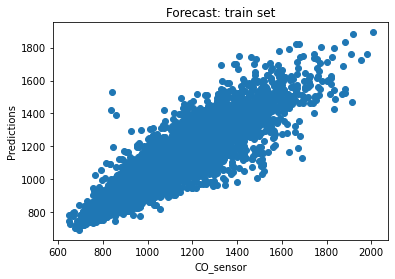

In [21]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: train set")

In [22]:
# The RMSE in the train set.

mean_squared_error(preds, y_train_t, squared=False)

91.67240601835518

On the train set, the model seems to be doing a decent job.

# Forecast 1 hour ahead in test set

We will evaluate the performance of the model in our test set now.

In [23]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,CO_lag_ave,month_sin,month_cos,hour_sin,hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,1047.0,1223.333333,1113.0,1.0,6.123234e-17,0.000000,1.000000,1039.513410
2005-03-04 01:00:00,3,9,4,4,1,0,929.0,1030.0,1104.666667,979.5,1.0,6.123234e-17,0.269797,0.962917,978.124528
2005-03-04 02:00:00,3,9,4,4,2,0,951.0,986.0,1019.666667,968.5,1.0,6.123234e-17,0.519584,0.854419,918.704120
2005-03-04 03:00:00,3,9,4,4,3,0,938.0,992.0,939.333333,965.0,1.0,6.123234e-17,0.730836,0.682553,880.855019
2005-03-04 04:00:00,3,9,4,4,4,0,921.0,1076.0,936.666667,998.5,1.0,6.123234e-17,0.887885,0.460065,864.211111


In [24]:
# Note that the prior 24 hr of information
# dissapeared from our test set (they had null data).

# Our dataset contains the first forecasting point
# as expected.

X_test_t.index.min(), X_test_t.index.max()

(Timestamp('2005-03-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [25]:
# Make predictions.

preds = lasso.predict(X_test_t)

preds[0:10]

array([1120.03389708,  890.71973879,  917.77699032,  918.47441179,
        910.1414645 ,  855.699437  ,  847.70489415,  929.6904844 ,
       1002.25279801, 1029.8363643 ])

In [26]:
print(y_test.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test.loc[X_test_t.index]

print(y_test_t.shape)

(567,)
(495,)


Text(0.5, 1.0, 'Forecast: test set')

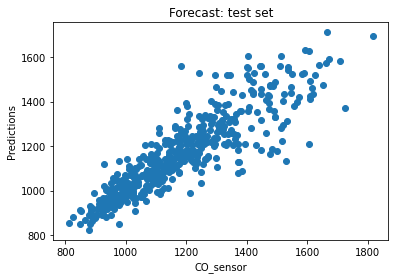

In [27]:
# Plot the predictions vs the truth.

plt.scatter(y_test_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: test set")

In [28]:
# RMSE in test set

mean_squared_error(preds, y_test_t, squared=False)

92.62517930172112

We see that our linear regression makes fairly good predictions of the pollutant concentration in the next hour.

That is all for this notebook, in the next one, we will add a step to benchmark our model using the train set.